In [1]:
# import packages
import re
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import pandas as pd
import statistics
import geopandas as gpd
from itertools import combinations

import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar

import cv2
import numpy as np
from shapely.geometry import Polygon

import warnings
warnings.filterwarnings('ignore')

In [2]:
#i/o
work_dir = '.'

sample_name_list = ['MERFISH 1','MERFISH 2','MERFISH 3', 'Slide-seq 1']

df_path_list = [work_dir + '/store/merfish_1_Updated_Spatial_Data.csv',
                work_dir + '/store/merfish_2_Updated_Spatial_Data.csv',
                work_dir + '/store/merfish_3_Updated_Spatial_Data.csv',
                work_dir + '/store/slide_seq_1_Updated_Spatial_Data.csv']

counts_path_list = [work_dir + '/data/HTAPP/HTAPP-944-SMP-7479/HTAPP-944-SMP-7479_1_merfish_counts.tsv.gz',
                    work_dir + '/data/HTAPP/HTAPP-944-SMP-7479/HTAPP-944-SMP-7479_2_merfish_counts.tsv.gz',
                    work_dir + '/data/HTAPP/HTAPP-944-SMP-7479/HTAPP-944-SMP-7479_3_merfish_counts.tsv.gz',
                    work_dir + '/data/HTAPP/HTAPP-944-SMP-7479/HTAPP-944-SMP-7479_1_slide_seq_counts.tsv.gz']

img_scale_list = [0.341, 0.345, 0.35, 0.65] #um/img px

BoReMi_img_path = work_dir + '/data/HTAPP/HTAPP-944-SMP-7479/HTAPP-944-SMP-7479_1_HE_lowres.jpg'

In [3]:
img = plt.imread(BoReMi_img_path)

In [4]:
# extract signel from H&E image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # change to gray scale
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV) # Threshold the grayscale image to get a binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # convert the "black" regions to polygons

(array([6.71064000e+05, 4.29371800e+06, 4.38423900e+06, 3.56040000e+06,
        3.25349000e+06, 3.04443500e+06, 2.74159200e+06, 2.49678400e+06,
        1.35113158e+08, 4.01897600e+06]),
 array([  6. ,  30.9,  55.8,  80.7, 105.6, 130.5, 155.4, 180.3, 205.2,
        230.1, 255. ]),
 <BarContainer object of 10 artists>)

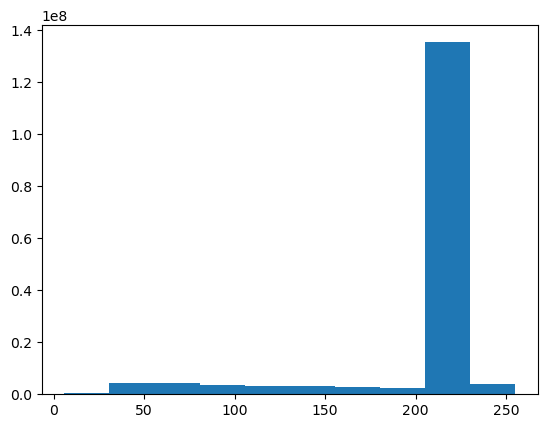

In [5]:
# plot signal intensity across image
plt.hist(gray.flatten())

<Axes: >

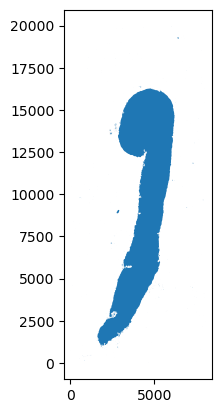

In [6]:
# convert mask to shapely polygons

polygons = []
for i in range(len(contours)): 
    if len(contours[i]) >= 3:
        polygon_points = contours[i].reshape(-1, 2) # Convert the contour to a polygon
        polygons.append(Polygon(polygon_points))

img_polygons = gpd.GeoDataFrame(geometry=polygons)
img_polygons.plot()

In [7]:
class BoReMi_alignment():
    def __init__(self, name, spatial_df_path, counts_path, img_scale, img):
        self.name = name

        # spatial coordinates
        self.spatial_df = pd.read_csv(spatial_df_path, index_col=0)
        self.spatial_df['flip initial y'] = img.shape[0] - self.spatial_df['initial y']
        self.spatial_df['flip final y'] = img.shape[0] - self.spatial_df['final y']
        self.scale = img_scale

        # counts
        self.counts = pd.read_csv(counts_path, delimiter='\t', compression='gzip', index_col=0).T
    

In [8]:
sample_list = []

for i in range(len(sample_name_list)):
    sample_list.append(BoReMi_alignment(sample_name_list[i], df_path_list[i], counts_path_list[i], img_scale_list[i],img))

In [9]:
def cal_overlap(sample, img_polygons):
    sample.spatial_df = gpd.GeoDataFrame(sample.spatial_df, geometry=gpd.points_from_xy(sample.spatial_df['final x'], sample.spatial_df['flip final y']))
    
    # Perform spatial join to find which points lie within which polygons
    points_within_polygons = gpd.sjoin(sample.spatial_df, img_polygons, how='inner', predicate='within')

    sample.spatial_df['overlap_img'] = 0
    sample.spatial_df.loc[sample.spatial_df.index.isin(points_within_polygons.index.tolist()), 'overlap_img'] = 1
    
    overlap_counts = sum(points_within_polygons.groupby('index_right').size())

    # Calculate the point / data overlap percentage
    total_points = len(sample.spatial_df)
    pt_overlap_percentage = (overlap_counts / total_points) * 100

    return overlap_counts, total_points, pt_overlap_percentage

In [10]:
for i in range(len(sample_name_list)):
    overlap_counts, total_points, pt_overlap_percentage = cal_overlap(sample_list[i], img_polygons)
    sample_list[i].overlap_counts = overlap_counts
    sample_list[i].total_points = total_points
    sample_list[i].pt_overlap_percentage = pt_overlap_percentage

    print(sample_list[i].name + ' : ' + str(pt_overlap_percentage))

MERFISH 1 : 96.0487571047045
MERFISH 2 : 96.3184983348471
MERFISH 3 : 95.19445847463743
Slide-seq 1 : 70.61257173361804


In [11]:
# create list of shared genes between all samples
shared_gene_list = list(set(sample_list[0].counts.columns) & set(sample_list[1].counts.columns) & set(sample_list[2].counts.columns) & set(sample_list[3].counts.columns))

In [12]:
# group gene counts by bin no.
bin_um_size = 100 # in um (length of edge of square bin)
scale = 0.34

bin_px_size = (1/scale)*bin_um_size # in img px (length of edge of square bin)

max_i = img.shape[1]//bin_px_size 
max_j = img.shape[0]//bin_px_size 

for a in range(len(sample_name_list)):
    bin_i = [] # x
    bin_j = [] # y
    bin_id = []
    
    for r in range(len(sample_list[a].spatial_df)):
        x = sample_list[a].spatial_df.iloc[r,2] # final x
        y = sample_list[a].spatial_df.iloc[r,5] # flip y
    
        bin_i.append(x//bin_px_size)
        bin_j.append(y//bin_px_size)
        bin_id.append(str(x//bin_px_size) + '_' + str(y//bin_px_size))

    sample_list[a].spatial_df['bin_i'] = bin_i
    sample_list[a].spatial_df['bin_j'] = bin_j

    sample_list[a].bin_counts = sample_list[a].counts
    sample_list[a].bin_counts['bin_id'] = bin_id
    sample_list[a].bin_counts = sample_list[a].bin_counts.groupby(['bin_id']).sum()


In [13]:
# find correlation between samples
comb = list(combinations(range(4), 2))

corr_dict = {}
corr_list_dict = {}

neg_corr_dict = {}
neg_corr_list_dict = {}

for c in range(len(comb)):
    sample1_idx = comb[c][0]
    sample2_idx = comb[c][1]

    corr_list = []
    neg_corr_list = []
    for g in shared_gene_list:
        compare_df = pd.merge(sample_list[sample1_idx].bin_counts[g], sample_list[sample2_idx].bin_counts[g], how = 'inner', left_index=True, right_index=True)
        corr_list.append(compare_df.corr(method='spearman').iloc[0,1])

        # negative control
        neg_sample_1 = compare_df.iloc[:,0].sample(frac=1).tolist()
        neg_sample_2 = compare_df.iloc[:,1].sample(frac=1).tolist()
        neg_ctrl_compare_df = pd.DataFrame(list(zip(neg_sample_1, neg_sample_2)), columns=compare_df.columns.tolist())
        neg_corr_list.append(neg_ctrl_compare_df.corr(method='spearman').iloc[0,1])

    corr_list_dict[comb[c]] = corr_list
    avg_corr = sum(corr_list) / len(corr_list)
    med_corr = statistics.median(corr_list)
    corr_dict[comb[c]] = [avg_corr, med_corr]


    neg_corr_list_dict[comb[c]] = neg_corr_list
    neg_avg_corr = sum(neg_corr_list) / len(neg_corr_list)
    neg_med_corr = statistics.median(neg_corr_list)
    neg_corr_dict[comb[c]] = [neg_avg_corr, neg_med_corr]

In [14]:
# find the common x and y range for plotting
plot_min_x = img.shape[1]/2
plot_max_x = img.shape[1]/2
plot_min_y = img.shape[0]/2
plot_max_y = img.shape[0]/2

for i in range(len(sample_name_list)):
    
    min_x = min(sample_list[i].spatial_df[['initial x', 'final x']].min())
    min_y = min(sample_list[i].spatial_df[['flip initial y', 'flip final y']].min())
    max_x = max(sample_list[i].spatial_df[['initial x' ,'final x']].max())
    max_y = max(sample_list[i].spatial_df[['flip initial y', 'flip final y']].max())

    plot_min_x = min(plot_min_x, min_x)
    plot_max_x = max(plot_max_x, max_x)
    plot_min_y = min(plot_min_y, min_y)
    plot_max_y = max(plot_max_y, max_y)


In [15]:
# create cmap to plot 
colors = ['#e6194b',  # red
          '#3cb44b'   # green
         ]

custom_cmap = ListedColormap(colors)

(0.0, 1.0, 0.0, 1.0)

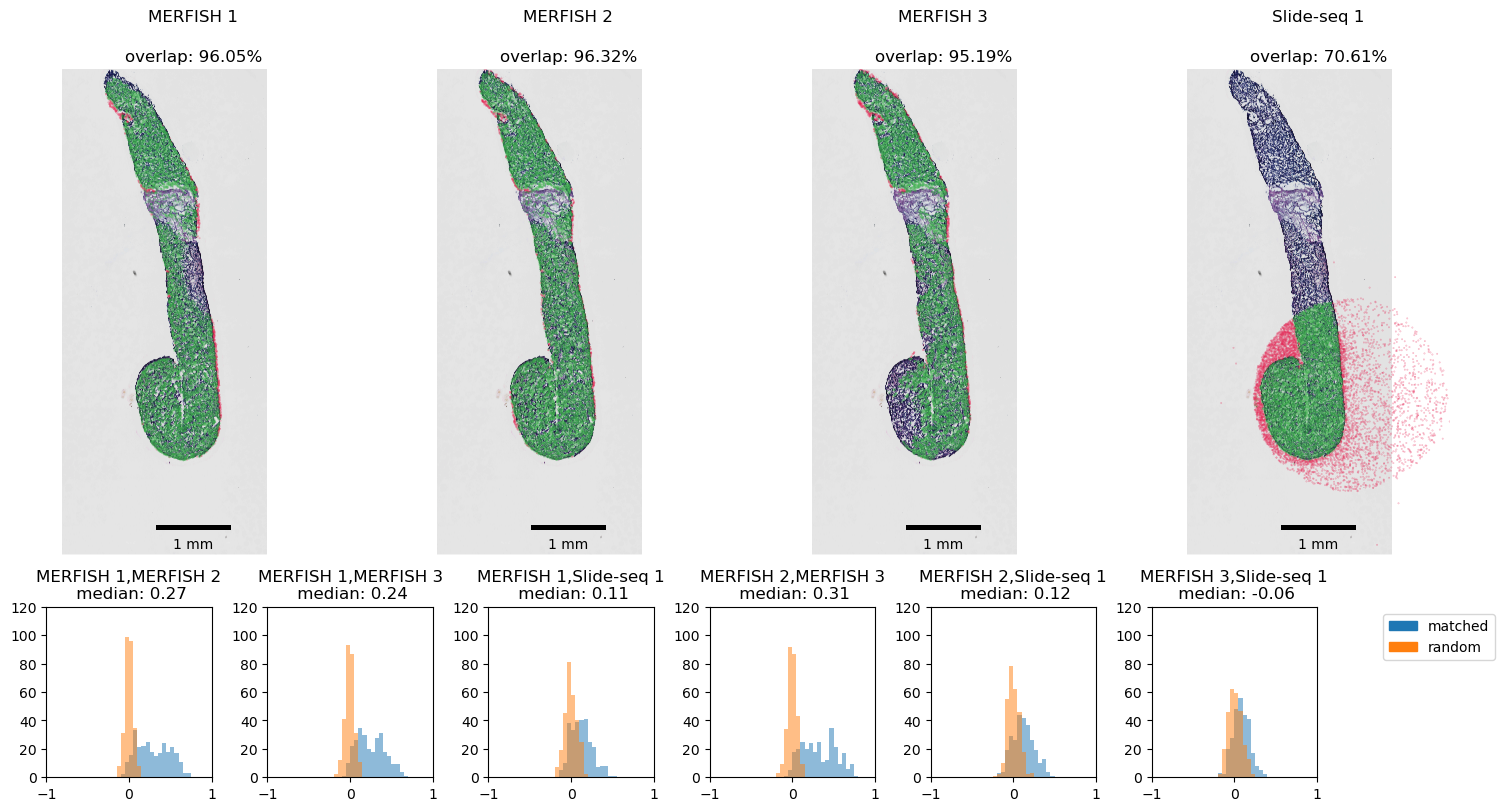

In [16]:
fig = plt.figure(layout='constrained', figsize=(15, 8))

# divide into 2 rows
subfigs = fig.subfigures(3, 1, wspace=0.07, height_ratios=[0.1, 1.5, 0.7])

# divide into diff columns per row
row0 = subfigs[0].subplots(1, 4)
row1 = subfigs[1].subplots(1, 4)
row2 = subfigs[2].subplots(1, 7)

for i in range(len(sample_name_list)):
    row0[i].set_title(sample_list[i].name)
    row0[i].axis('off')
    
    # after
    row1[i].imshow(img)
    row1[i].scatter(sample_list[i].spatial_df['final x'], sample_list[i].spatial_df['flip final y'], s=0.1, alpha=0.4, rasterized = True, c=sample_list[i].spatial_df['overlap_img'], cmap=custom_cmap)
    row1[i].axis('off')
    row1[i].set_aspect(aspect='equal')
    row1[i].set_xlim(plot_min_x, plot_max_x)
    row1[i].set_ylim(plot_min_y, plot_max_y)
    row1[i].invert_yaxis()
    row1[i].set_title('overlap: ' + str(round(sample_list[i].pt_overlap_percentage, 2)) + '%')

    ##### scale bar
    scalebar = ScaleBar(0.00034, 'mm', location='lower center', width_fraction=0.01, color='black', box_alpha=0, fixed_value=1) 
    row1[i].add_artist(scalebar)

bins = np.arange(-1, 1.1, 0.05)
for c in range(len(comb)):
    row2[c].hist(corr_list_dict[comb[c]], alpha=0.5, bins=bins)
    row2[c].hist(neg_corr_list_dict[comb[c]], alpha=0.5, bins=bins)
    row2[c].set_title(sample_list[comb[c][0]].name + ',' + sample_list[comb[c][1]].name + '\n median: ' + str(round(corr_dict[comb[c]][1], 2)))
    row2[c].set_xlim(-1,1)
    row2[c].set_ylim(0,120)

patch_list = []
patch_list.append(mpatches.Patch(color='#1f77b4', label='matched'))
patch_list.append(mpatches.Patch(color='#ff7f0e', label='random'))
row2[6].legend(handles=patch_list)
row2[6].axis('off')

In [17]:
fig.savefig(work_dir + '/store/HTAPP_944_after_BoReMi.svg')